In [1]:
from data_etl import data_etl
from feature_addition import feature_addition
import utils
import pandas as pd
import numpy as np
from utils import fit_by_id_cols
from utils import customScaler
import copy
from utils import final_features
from Models.Models import LinearRegression,ElasticNet,LinearSVR
from pipeline import pipeline
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## Setup: 

Since this is sort of a time series data, we will implement the a WalkForward methodology.

##### Training Data/CV: 
This done over all the years till 2018 ( approx. 92% of data). With a minimum of 7 years worth of data, we train the model every year and test on the coming year. The “Y” column is the log change of Sales for the Sec ID.
 
##### Test data: 
As before, model is retrained every year from 2019 till 2020 (because thats the final year till which next year's data is available for returns). The tst ratio is used to find the nearest year for which to start testing from, so 5% tst ratio actually gets you about 8% testing data.

##### Model Evaluation
At the end when evaluating the model, we will evaluate on the basis of actual sales MSE score. We evaluate every thing against the base model which assumes 0 change in Sales.



In [2]:
dir='Data/data_science_challenge_dataset.csv'

tst_ratio=0.05
scalerFuncDic={'12M_MOMENTUM':'StandardScaler','WEEKLY_MOMENTUM':'StandardScaler','12M_SALES_ratio':'StandardScaler',\
               '12M_to_Weekly_Avg_YTD':'StandardScaler', 'R&D_12M_ratio':'StandardScaler','TOTAL_ASSETS_YTD_AVG_spread':'StandardScaler',\
              'SALES_YTD_AVG_spread':'StandardScaler','12M_MOMENTUM_YTD_AVG_spread':'StandardScaler','WEEKLY_MOMENTUM_YTD_AVG_spread':'StandardScaler'}
raw_features=['12M_MOMENTUM', 'R&D_EXP', 'SALES', 'TOTAL_ASSETS', 'WEEKLY_MOMENTUM']

pipeline_run=pipeline(tst_ratio,scalerFuncDic,dir,raw_features)


## Data scrubbing:

1) R&D Expenses has most missing values, but that number looks like 0 for missing values

2) Data distribution by year and security id graph shows usually a security occurs only once in a year as it should, but sometimes they appear in the
same year 2 times. Hence we "adjust" the year

3) We see Sales itself has bimodal distrubtion by IDs (top 6 ids observed), but log returns are normally distributed, so we will focus on 
forecasting the log returns. For every security ID we find the log sales change over the coming year.

4) Finally we look at correlation plot of the raw features after our scrubbing.




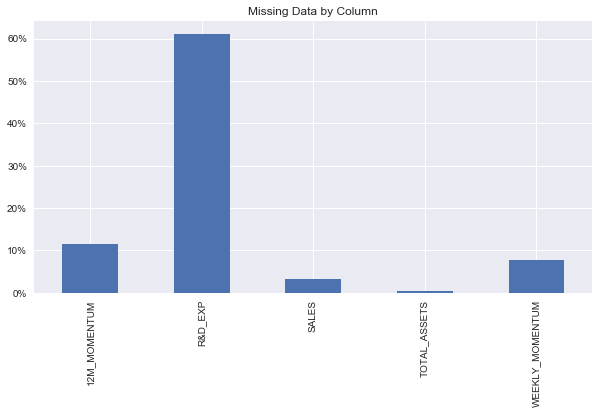

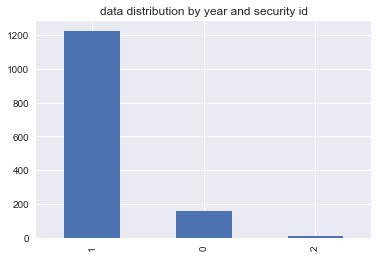

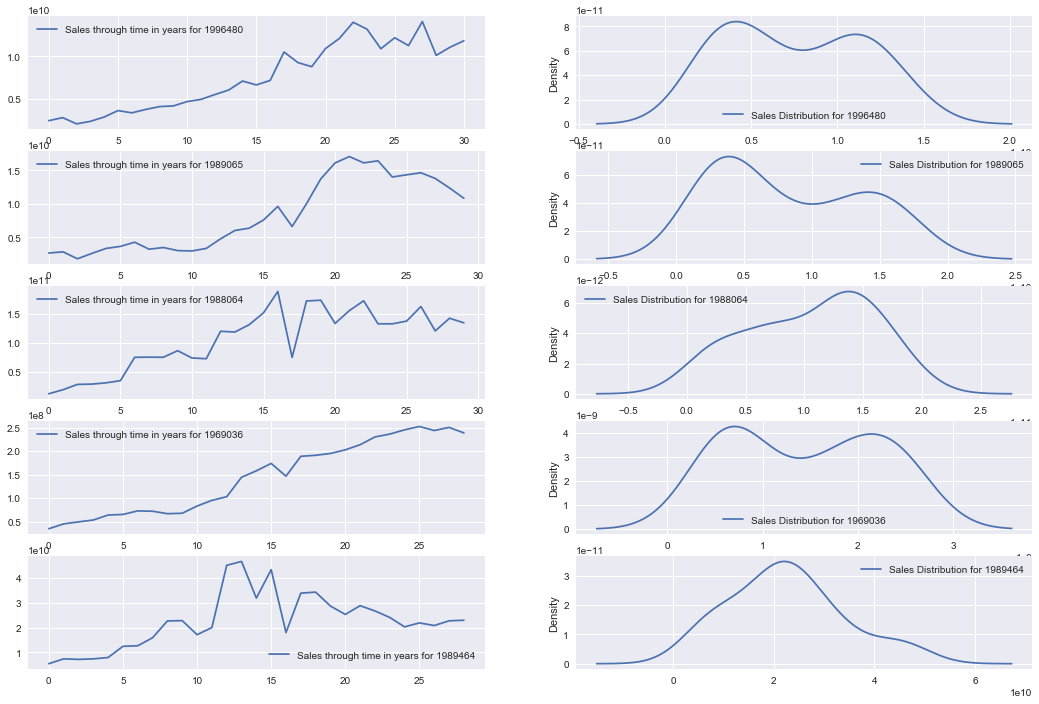

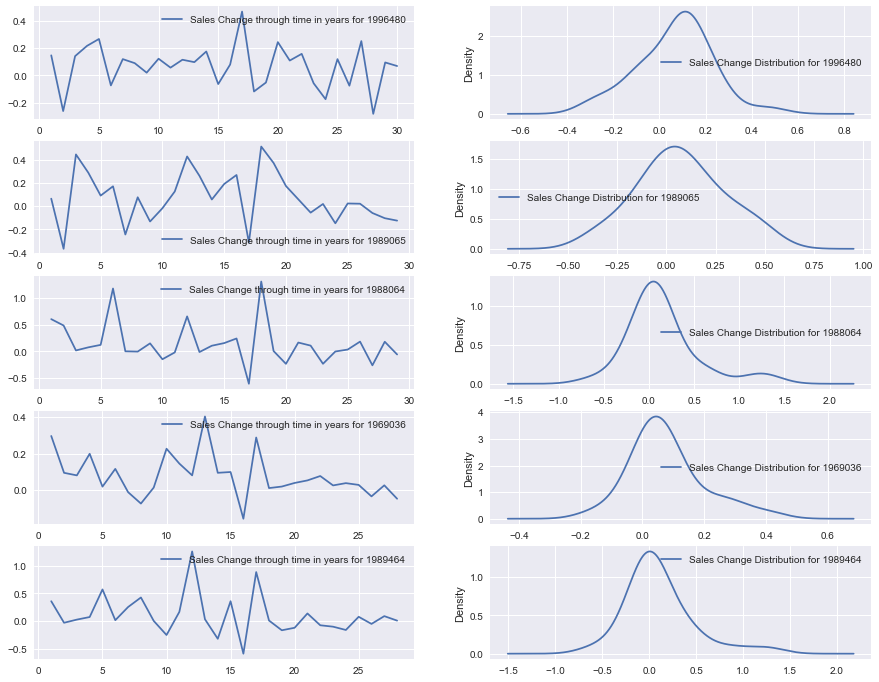

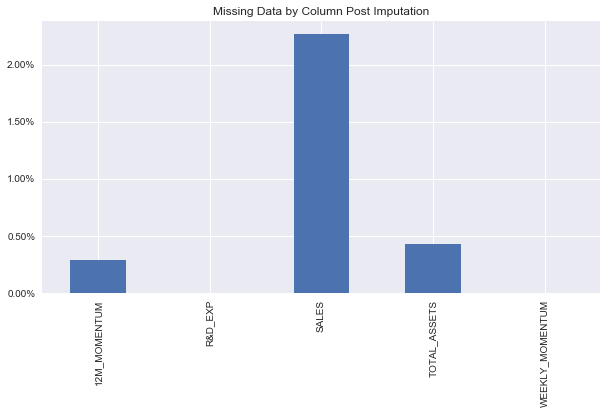

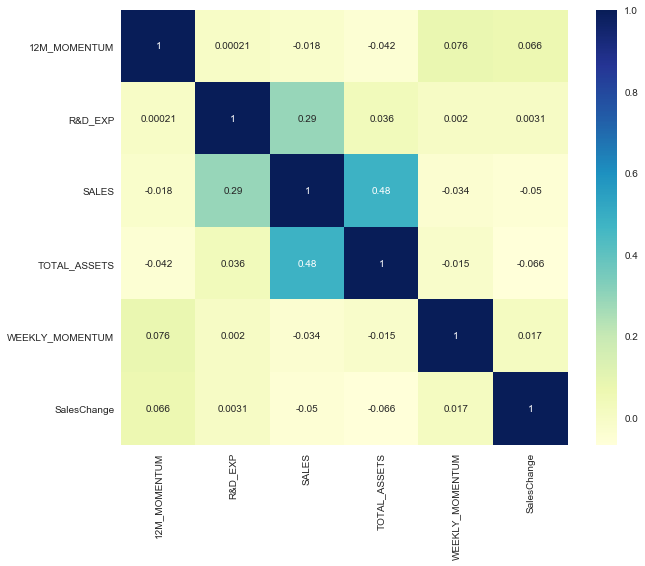

In [3]:
pipeline_run.cleaned_data()

## Feature Addition/Engineering (Pre Scaling)

1) After a little bit of imputation, we get the missing data down even more and so we drop the missing value rows. We also ignore cases where the returns >100%

2) We add additionaly features and run the correlation matrix. Summary of the features description is found in the appendix below.

We notice we have about 1196 data points available against raw 1410 (1267 post imputation)


data remaining 1196 vs original data length post imputation 1267


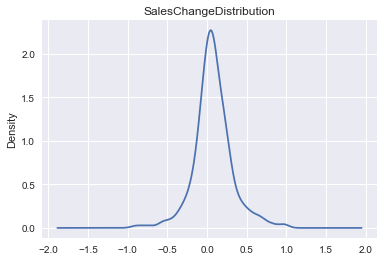

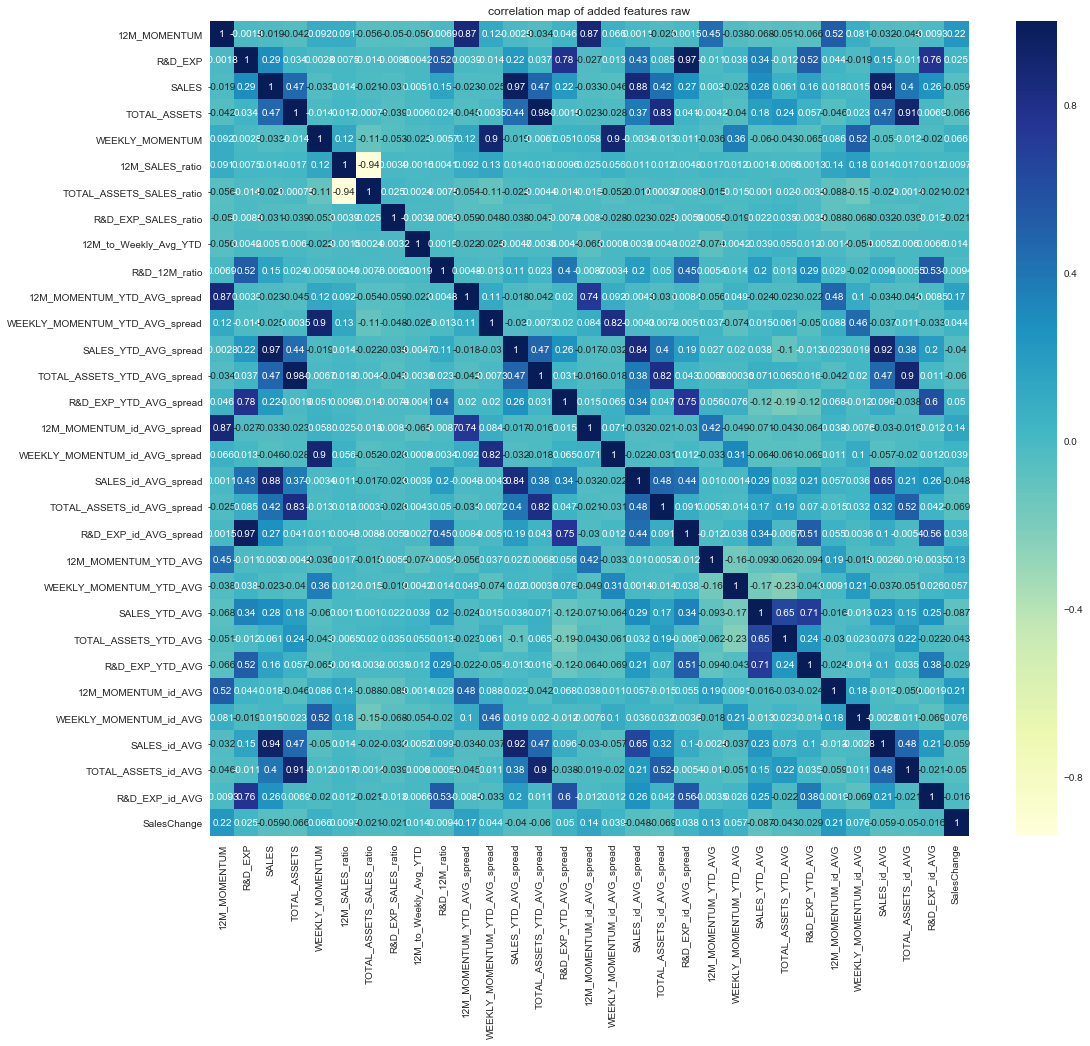

In [4]:
pipeline_run.add_features()

## Scaling

We scale all of our data using our methodology described in the  report but also below:Scaling is done for every year as to scale it with respect to the data till that year. Depending on the variable, it is scaled in the following way:

1) By ID and Min Max: features only make sense in the context of their respective IDs and can never have negative values, so we scale as this. 

2) By ID and StandardScaler: features only make sense in the context of their respective IDs and can have negative values, so we scale as this

3) By Time and Min Max:features make sense in the context of their Time and can never have negative values, so we scale as this

4) By Time and StandardScaler: features make sense in the context of their Time and can have negative values, so we scale as this

In [5]:
pipeline_run.run_scaler()

Scaling on data till 1991 for data for year 1992
Scaling on data till 1992 for data for year 1993
Scaling on data till 1993 for data for year 1994
Scaling on data till 1994 for data for year 1995
Scaling on data till 1995 for data for year 1996
Scaling on data till 1996 for data for year 1997
Scaling on data till 1997 for data for year 1998
Scaling on data till 1998 for data for year 1999
Scaling on data till 1999 for data for year 2000
Scaling on data till 2000 for data for year 2001
Scaling on data till 2001 for data for year 2002
Scaling on data till 2002 for data for year 2003
Scaling on data till 2003 for data for year 2004
Scaling on data till 2004 for data for year 2005
Scaling on data till 2005 for data for year 2006
Scaling on data till 2006 for data for year 2007
Scaling on data till 2007 for data for year 2008
Scaling on data till 2008 for data for year 2009
Scaling on data till 2009 for data for year 2010
Scaling on data till 2010 for data for year 2011
Scaling on data till

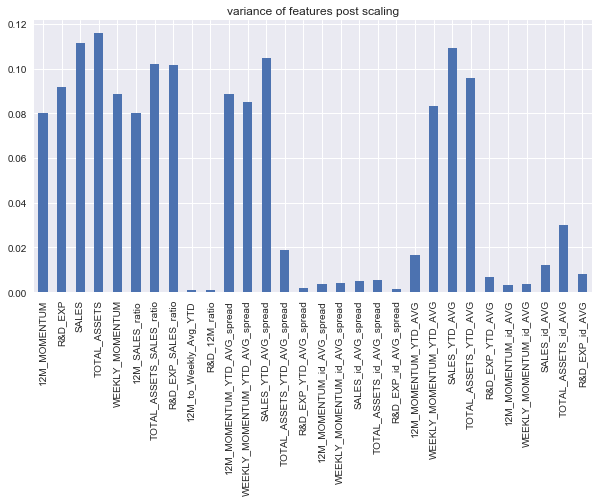

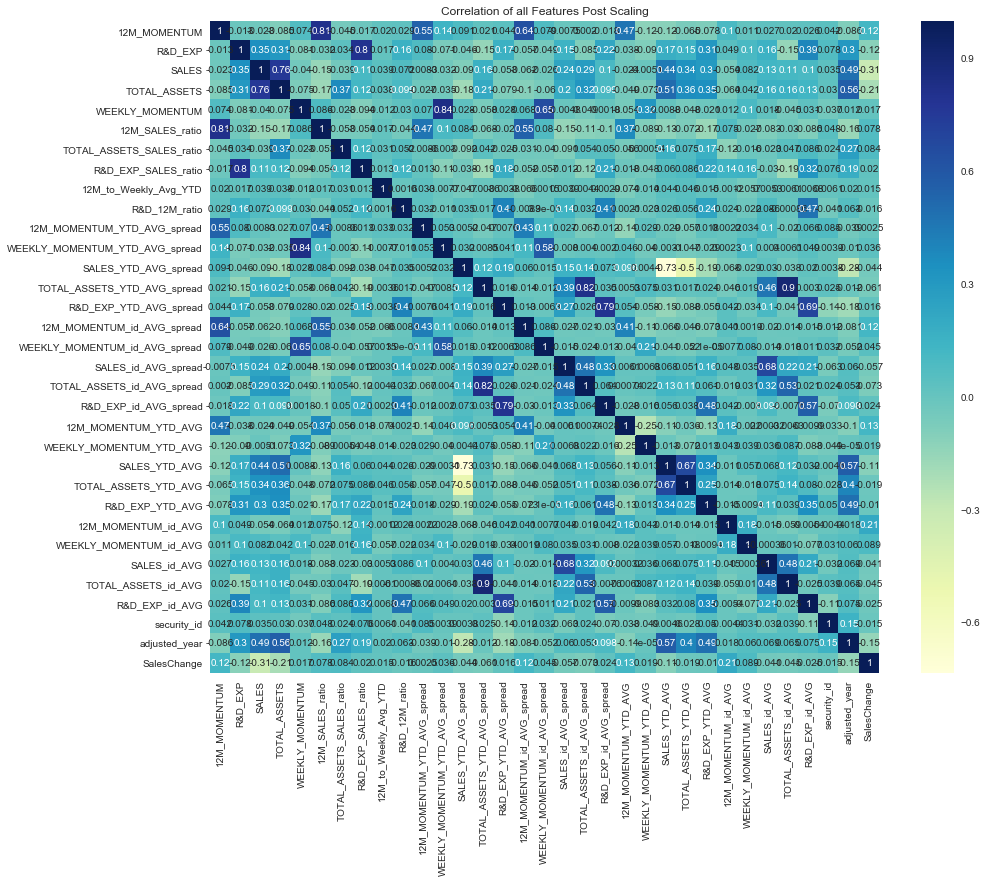

In [6]:
pipeline_run.show_post_scaled_variance_on_all_data()

## Linearity Assumption - No multi collinearity:

We iteratively filter out variables that have a Variance Inflation Factor>10

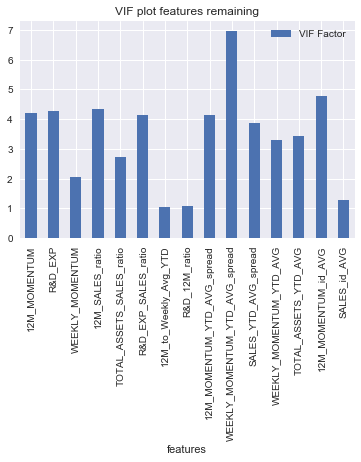

In [7]:
pipeline_run.get_uncorrelated_variables()

## Elastic

We run Elastic Regression with a .1 alpha and .1 L1-ratio as the model is very sensitive to coefficient size as the features are scaled and also the independent variable is expressed in returns. 

We observe the stability of the coeffecients and the distribution of errors of the CV set to be not as normally distributed as we would like.

done model 0,performance on train return 0.06185717385852596
{'alpha': 0.1, 'fit_intercept': False, 'l1_ratio': 0.1, 'normalize': False}


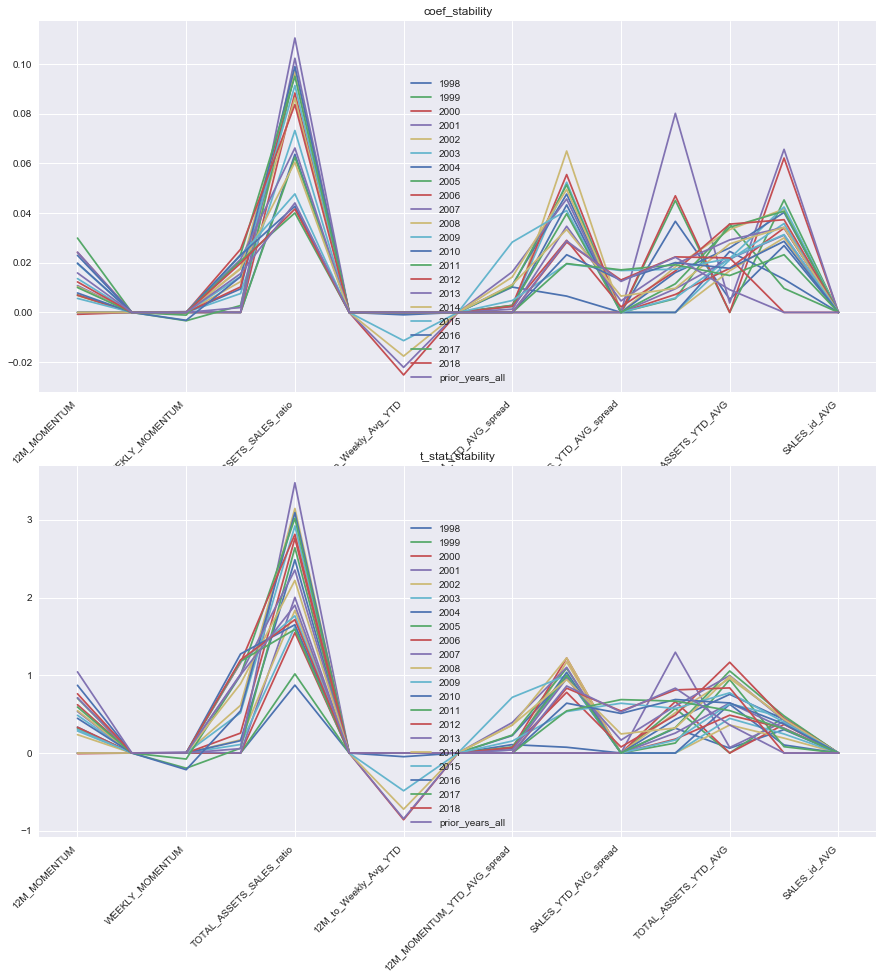

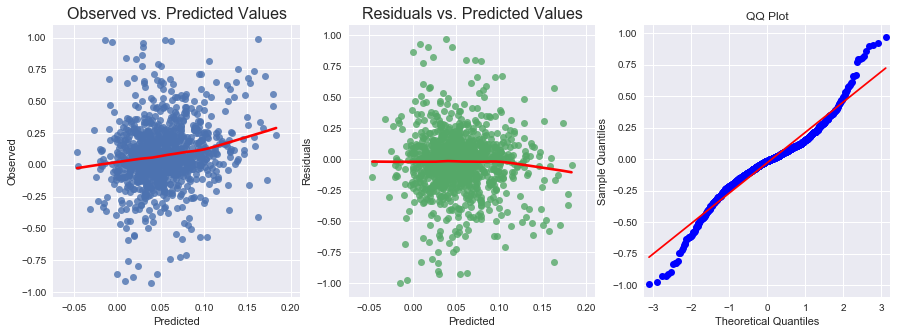

In [8]:
all_feats=[copy.deepcopy(pipeline_run.final_features_use)]
param_dict={'fit_intercept':[False],'normalize':[False],'alpha':[.1],'l1_ratio':[.1]}
model_use=ElasticNet
model_name='Elastic'
res_elastic,coef_stability_elastic,mW_elastic=pipeline_run.run_model(model_use,all_feats,param_dict,model_name,max_train_data=None)

In [9]:
params_filtered=[*coef_stability_elastic.loc[abs(coef_stability_elastic.prior_years_all)>.00001].index]
print(params_filtered,len(params_filtered))

['12M_MOMENTUM', '12M_SALES_ratio', 'TOTAL_ASSETS_SALES_ratio', 'WEEKLY_MOMENTUM_YTD_AVG_spread', 'SALES_YTD_AVG_spread', 'WEEKLY_MOMENTUM_YTD_AVG', 'TOTAL_ASSETS_YTD_AVG'] 7


## Linear Model

We evaluate Linear regression with all features and only the features selected as per 1). We notice the better model is the one with fewer features as per CV scoring.

We observe the stability of the coeffecients and the distribution of errors to be not as normally distributed as we would like.


done model 0,performance on train return 0.07091989257710003
done model 1,performance on train return 0.06670139055152073
done model 2,performance on train return 0.07085737849621687
done model 3,performance on train return 0.06832848685793845
{'fit_intercept': False}


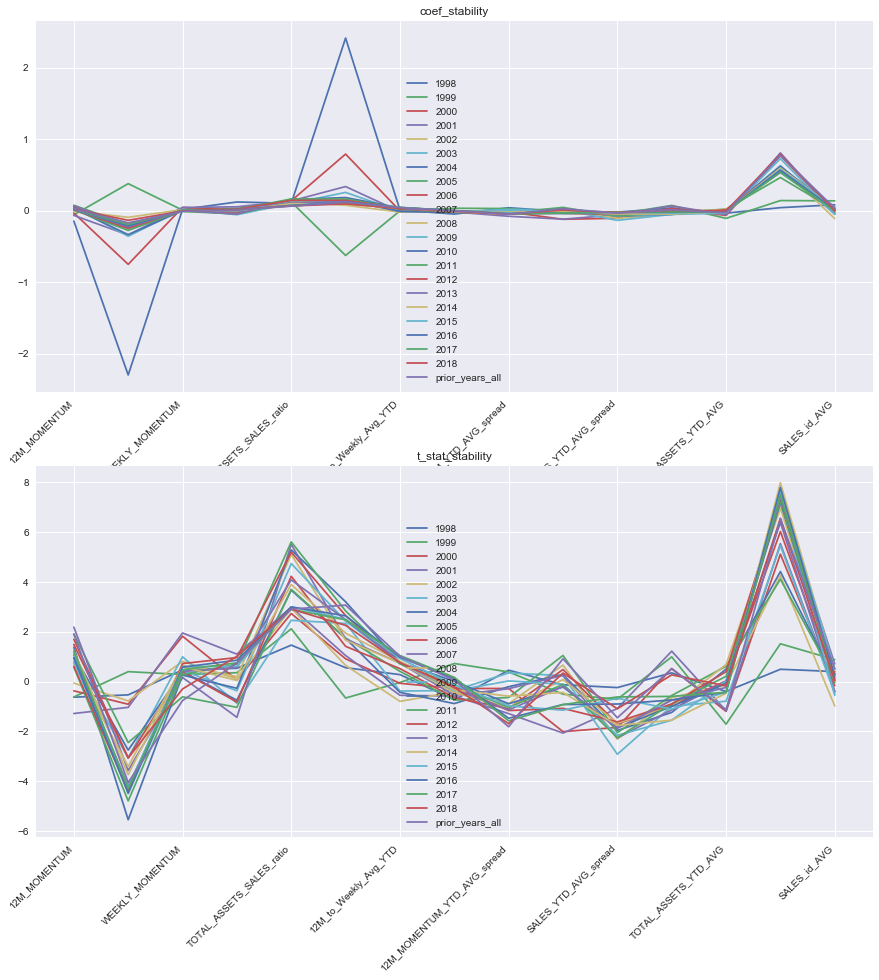

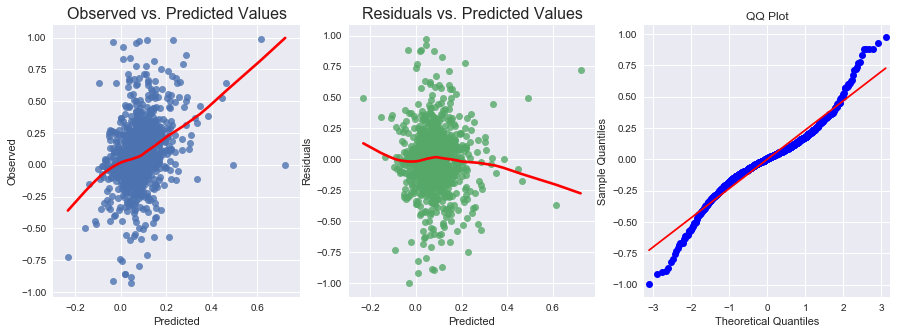

In [10]:
param_dict={'fit_intercept':[True,False]}
all_feats=[copy.deepcopy(pipeline_run.final_features_use)]
all_feats.append(params_filtered)
model_use=LinearRegression
model_name='Linear'
res_linear,coef_stability_linear,mW_Linear=pipeline_run.run_model(model_use,all_feats,param_dict,model_name,max_train_data=None)

In [11]:
print([*coef_stability_linear.index])

['12M_MOMENTUM', 'R&D_EXP', 'WEEKLY_MOMENTUM', '12M_SALES_ratio', 'TOTAL_ASSETS_SALES_ratio', 'R&D_EXP_SALES_ratio', '12M_to_Weekly_Avg_YTD', 'R&D_12M_ratio', '12M_MOMENTUM_YTD_AVG_spread', 'WEEKLY_MOMENTUM_YTD_AVG_spread', 'SALES_YTD_AVG_spread', 'WEEKLY_MOMENTUM_YTD_AVG', 'TOTAL_ASSETS_YTD_AVG', '12M_MOMENTUM_id_AVG', 'SALES_id_AVG']


## LinearSVR

We do the same thing above with Linear SVR, and we notice this one picked up all the features.

done model 0,performance on train return 0.06199969618796345
done model 1,performance on train return 0.06337339681415578
done model 2,performance on train return 0.06364035342189993
done model 3,performance on train return 0.06527709315528338
done model 4,performance on train return 0.06254182615783774
done model 5,performance on train return 0.06496209442910753
done model 6,performance on train return 0.064135415489541
done model 7,performance on train return 0.06672542678834414
done model 8,performance on train return 0.06285236269362589
done model 9,performance on train return 0.06416249351828582
done model 10,performance on train return 0.06444993316978674
done model 11,performance on train return 0.06601408481765723
done model 12,performance on train return 0.06385388496608767
done model 13,performance on train return 0.06570792898780685
done model 14,performance on train return 0.06478172825359196
done model 15,performance on train return 0.06758076122635334
done model 16,perfor

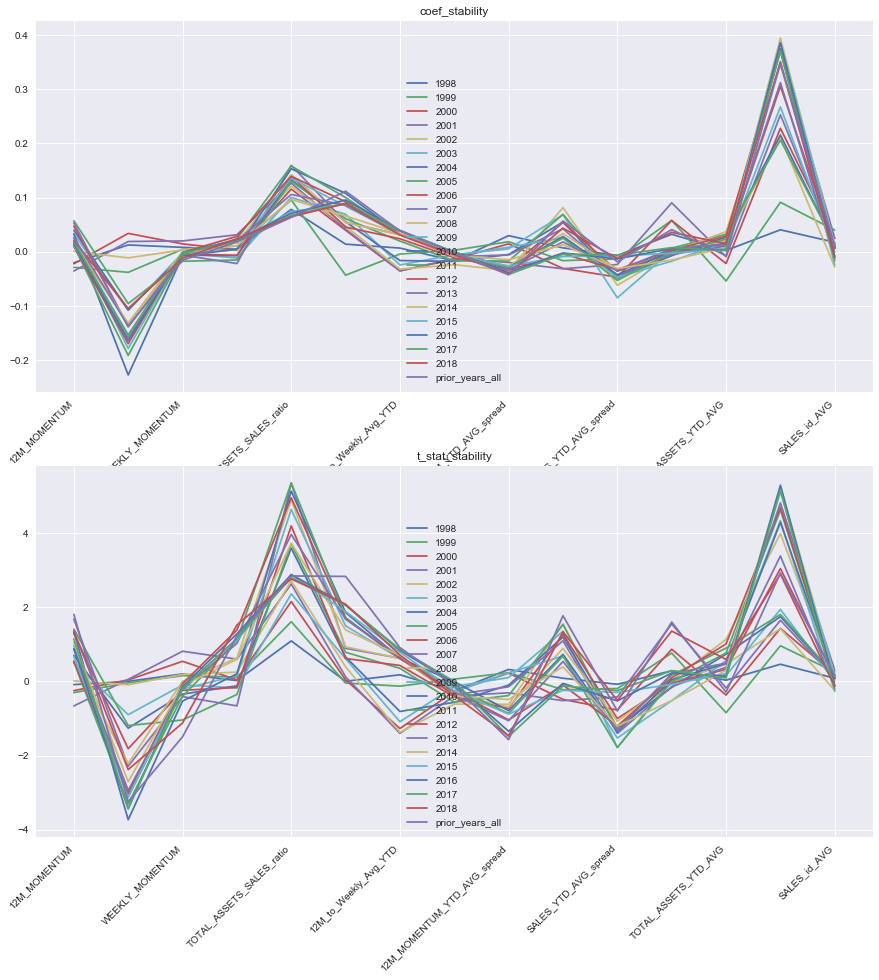

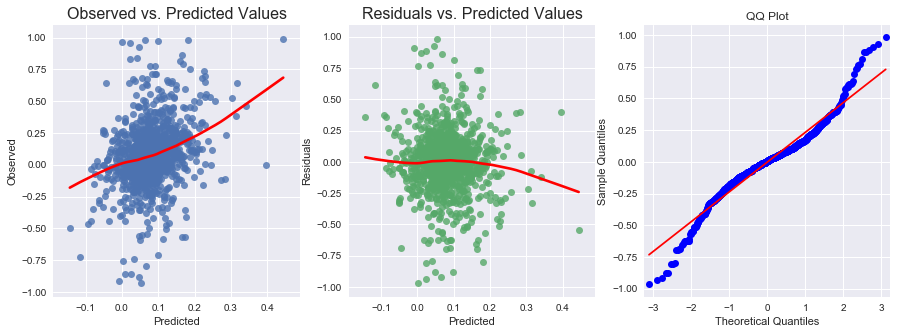

In [12]:
param_dict={'fit_intercept':[True,False],'C':[.1,.5,1],'loss':['epsilon_insensitive', 'squared_epsilon_insensitive'],'random_state':[0]}
all_feats=[copy.deepcopy(pipeline_run.final_features_use)]
all_feats.append(params_filtered)
model_use=LinearSVR
model_name='LinearSVR'
res_linearSVR,coef_stability_linearSVR,mW_LinearSVR=pipeline_run.run_model(model_use,all_feats,param_dict,model_name,max_train_data=None)

In [13]:
print([*coef_stability_linearSVR.index])


['12M_MOMENTUM', 'R&D_EXP', 'WEEKLY_MOMENTUM', '12M_SALES_ratio', 'TOTAL_ASSETS_SALES_ratio', 'R&D_EXP_SALES_ratio', '12M_to_Weekly_Avg_YTD', 'R&D_12M_ratio', '12M_MOMENTUM_YTD_AVG_spread', 'WEEKLY_MOMENTUM_YTD_AVG_spread', 'SALES_YTD_AVG_spread', 'WEEKLY_MOMENTUM_YTD_AVG', 'TOTAL_ASSETS_YTD_AVG', '12M_MOMENTUM_id_AVG', 'SALES_id_AVG']


## Final Model Evaluation

Based on the CV results and true out of sample testing (30% of data - 2018 fwd) we find Linear Regression or LinearSVR to be the best model.


In [14]:
pd.options.display.float_format = '{:.3}'.format
def get_vals(res):
    res=copy.deepcopy(res)
    return pd.Series({'Test_Returns_MSE':res['MSE_test_walk_fwd_ret'],'Test_Sales_MSE':res['MSE_test_walk_fwd_actual_sales'],'CV_Train_MSE_returns':res['MSE_train_walk_fwd_ret'],'CV_Train_Sales_MSE':res['MSE_train_walk_fwd_actual_sales']})

base_res_ser=pd.Series({'Test_Returns_MSE':res_linear['MSE_test_walk_fwd_ret_base'],'Test_Sales_MSE':res_linear['MSE_test_walk_fwd_actual_sales_base'],'CV_Train_MSE_returns':res_linear['MSE_train_walk_fwd_ret_base'],'CV_Train_Sales_MSE':res_linear['MSE_train_walk_fwd_actual_sales_base']})
performance_df=pd.concat([base_res_ser.rename('base'),get_vals(res_elastic).rename('elastic'),\
           get_vals(res_linear).rename('linear'),get_vals(res_linearSVR).rename('linearSVR')],axis=1)

performance_df.T

,Test_Returns_MSE,Test_Sales_MSE,CV_Train_MSE_returns,CV_Train_Sales_MSE
base,0.0521,6.13e+20,0.0674,1.99e+20
elastic,0.0498,5.69e+20,0.0619,2.11e+20
linear,0.0451,4.91e+20,0.0709,1.83e+20
linearSVR,0.0452,4.83e+20,0.0641,1.78e+20


In [15]:
pd.options.display.float_format = '{:.2%}'.format
for col in performance_df.columns:
    performance_df[col+'_change_to_base']=1-performance_df[col]/performance_df['base']
performance_df.T.iloc[4:]

,Test_Returns_MSE,Test_Sales_MSE,CV_Train_MSE_returns,CV_Train_Sales_MSE
base_change_to_base,0.00%,0.00%,0.00%,0.00%
elastic_change_to_base,4.41%,7.28%,8.27%,-5.67%
linear_change_to_base,13.48%,19.94%,-5.08%,8.16%
linearSVR_change_to_base,13.21%,21.24%,4.89%,10.56%


## Appendix: All features considered (and used post analysis)


In [2]:

pd.read_csv('Data/featureDescription.csv').set_index('Feature').fillna('N')

,Description,Scaling Method,Feature kept?
Feature,,,
12M_MOMENTUM,Raw Feature,StandardScaler by ID,Y
R&D_EXP,Raw Feature,MinMaxScaler by ID,Y
SALES,Raw Feature,MinMaxScaler by ID,N
TOTAL_ASSETS,Raw Feature,MinMaxScaler by ID,N
WEEKLY_MOMENTUM,Raw Feature,StandardScaler by ID,Y
12M_SALES_ratio,12M_MOMENTUM/SALES,StandardScaler by ID,Y
TOTAL_ASSETS_SALES_ratio,TOTAL_ASSETS/SALES,MinMaxScaler by ID,Y
R&D_EXP_SALES_ratio,R&D/SALES,MinMaxScaler by ID,Y
12M_to_Weekly_Avg_YTD,12M_MOMENTUM/WEEKLY_MOMENTUM,StandardScaler by ID,Y
